In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['mathtext.fontset'] = 'stix'

In [3]:
# --- 5mmol@3m DP ---
D = 5e-10  # 分子扩散系数 m2/s
L = 0.02  # 土柱高度 m
H = 3  # 水头差 m
c0 = 0.005  # 初始入流浓度 mol/L
Gs = 2.6
wf = 2.3 # 初始含水率
kd = 15 #L/g
ita = 0.6# 大孔隙区域占比系数

# --- 实测渗透系数 ---
k0 = 2e-10 #m/s
kf = 4e-10 #m/s

# --- 密度 ---
ruo_0 = 1.285 # 初始密度 g/cm3
ruo_d = ruo_0/(1+wf)  # 干密度 g/cm3
ruo_f = ruo_d * (1+1.2)

# --- 孔隙比 ---
e0 = Gs*(1+wf)/ruo_0-1
ef = Gs*1.2

# --- 时间空间网格 ---
time_max = 86400 * 40  # 模拟总时间 40天
dt = 3600  # 时间步长 1小时
space_node = 100  # 空间网格点数
dx = L / (space_node - 1)  # 空间步长
time_steps = int(time_max / dt)

# --- 孔隙率 ---
n0 = e0/(1+e0)
nf = ef/(1+ef)

# --- 阻滞系数 ---
R = kd*ruo_d/nf+1

# --- 大孔隙区域参数 ---
theta_m = np.full(space_node, n0*0.6)
R_m = np.full(space_node, R*ita)

# --- 小孔隙区域参数 ---
theta_im = np.full(space_node, n0 - n0*0.6)
R_im = np.full(space_node, R*(1-ita))

# --- 双孔隙模型参数 ---
omega = 1e-5  # 两域间质量传递系数 ω
alpha = omega  # 小孔隙方程中的质量传递系数 α

# ===== 计算达西流速 =====
v = k0 * H / L  # 平均达西流速
theta_m_v = theta_m * v  # (θ_m * v)_i^n

# ===== 初始化变量 =====
time = 0
BTC_result = []  # 存储突破曲线结果
C_m = np.zeros(space_node)   # 大孔隙浓度 C_m,i^n
C_im = np.zeros(space_node)  # 小孔隙浓度 C_im,i^n
x = np.linspace(0, L, space_node)

# --- 采样设置 ---
sample_interval = 86400  # 1天采样一次
next_sample_time = sample_interval

print(f"开始时间循环求解...")
print(f"总时间步数: {time_steps}")
print(f"空间节点数: {space_node}")
print(f"达西流速: {v:.2e} m/s")

开始时间循环求解...
总时间步数: 960
空间节点数: 100
达西流速: 3.00e-08 m/s


In [50]:
print(R)

8.712995337995338


# DP 控制方程

${ R_m \frac{\partial \theta_m C_m}{\partial t} = D_m \frac{\partial}{\partial x} \left( \theta_m \frac{\partial C_m}{\partial x} \right) - \frac{\partial (v C_m)}{\partial x} - \omega (C_m - C_{im}) }$

$R_{im} \frac{\partial \theta_{m} C_{m}}{\partial t} = \omega (C_{m} - C_{m})$<br>

## 离散化后目标得到

$A_i C_{m,j}^{n+1} + B_i C_{m,j}^{n+1} + E_i C_{m,j-1}^{n+1} = F_i$<br>

$A_i = -\frac{D}{\Delta x^2} \cdot \frac{\theta_{m,i}^n + \theta_{m,i-1}^n}{2} - \frac{(\theta_m v)_i^n + (\theta_m v)_{i-1}^n}{2 \Delta x}$<br>
$B_i = \frac{R_{m,i}^n \theta_{m,i}^n}{\Delta t} + \frac{D}{2 \Delta x^2} (2 \theta_{m,j}^n + \theta_{m,i+1}^n + \theta_{m,i-1}^n) + \frac{(\theta_m v)_i^n + (\theta_m v)_{i+1}^n}{2 \Delta x} + \omega$<br>
$E_i = -\frac{D}{\Delta x^2} \cdot \frac{\theta_{m,i}^n + \theta_{m,i+1}^n}{2}$<br>
$F_i = \frac{R_{m,i}^n \theta_{m,i} C_{m,i}^n}{\Delta t} + \omega C_{im,i}^n$<br>
$C_{im,i}^{n+1} = \frac{\frac{\theta_{im,i}^{n} R_{im,i}^{n} C_{im,i}^{n}}{\Delta t }}{\frac{\theta_{im,i}^{n} R_{im,i}^{n}}{\Delta t} + \omega} + \omega C_{m,i}^{n}$<br>


In [4]:
# ===== 时间循环 =====
for t_step in range(time_steps):
    time += dt

    # 保存上一时间步的浓度 (n时间步)
    C_m_n = C_m.copy()
    C_im_n = C_im.copy()

    # === 构建大孔隙区域矩阵 (求解 n+1 时间步) ===
    A_matrix = lil_matrix((space_node, space_node))
    F_vector = np.zeros(space_node)

    # 边界条件：x=0处固定入流浓度 (i=0)
    A_matrix[0, 0] = 1.0
    F_vector[0] = c0

    # 内部节点 (i=1 to space_node-2)
    for i in range(1, space_node-1):

        A_i = (-D/dx**2) * (theta_m[i] + theta_m[i+1])/2 - (theta_m_v[i] + theta_m_v[i+1])/(2*dx)

        E_i = (-D/dx**2) * (theta_m[i] + theta_m[i-1])/2 + (theta_m_v[i] + theta_m_v[i-1])/(2*dx)

        B_i = (R_m[i] * theta_m[i] / dt +
               D/(2*dx**2) * (2*theta_m[i] + theta_m[i+1] + theta_m[i-1]) +
               (theta_m_v[i+1] - theta_m_v[i-1])/(2*dx) + omega)

        # 填充矩阵
        A_matrix[i, i-1] = E_i  # C_{m,i-1}^{n+1} 的系数
        A_matrix[i, i] = B_i    # C_{m,i}^{n+1} 的系数
        A_matrix[i, i+1] = A_i  # C_{m,i+1}^{n+1} 的系数

        # F_i 右端项：包含上一时间步的项
        F_vector[i] = (R_m[i] * theta_m[i] * C_m_n[i] / dt + omega * C_im_n[i])

    # 边界条件：x=L处无扩散边界（零梯度）(i=space_node-1)
    A_matrix[space_node-1, space_node-2] = -1.0
    A_matrix[space_node-1, space_node-1] = 1.0
    F_vector[space_node-1] = 0.0

    # === 求解大孔隙方程得到 C_m^{n+1} ===
    C_m = spsolve(A_matrix.tocsr(), F_vector)

    # === 根据小孔隙方程计算 C_im^{n+1} ===
    for i in range(space_node):
        denominator = theta_im[i] * R_im[i] / dt + alpha
        term1 = (theta_im[i] * R_im[i] * C_im_n[i] / dt) / denominator
        term2 = (alpha * C_m_n[i]) / denominator  #  C_m^n (上一时间步)
        C_im[i] = term1 + term2

    # === 数据采样和存储 ===
    if time >= next_sample_time:
        # 计算总浓度（体积加权平均）
        C_total = (theta_m * C_m + theta_im * C_im) / (theta_m + theta_im)

        # 存储突破曲线数据（末端浓度）
        BTC_result.append({
            'time_days': time / 86400,
            'C_ma_outlet': C_m[-1],
            'C_im_outlet': C_im[-1],
            'C_total_outlet': C_total[-1]
        })

        next_sample_time += sample_interval

        # 打印进度
        # if len(BTC_result) % 5 == 0:
        #     print(f"已完成 {time/86400:.1f} 天，大孔隙出口: {C_m[-1]:.6f}, 小孔隙出口: {C_im[-1]:.6f}, 总出口: {C_total[-1]:.6f} mol/L")

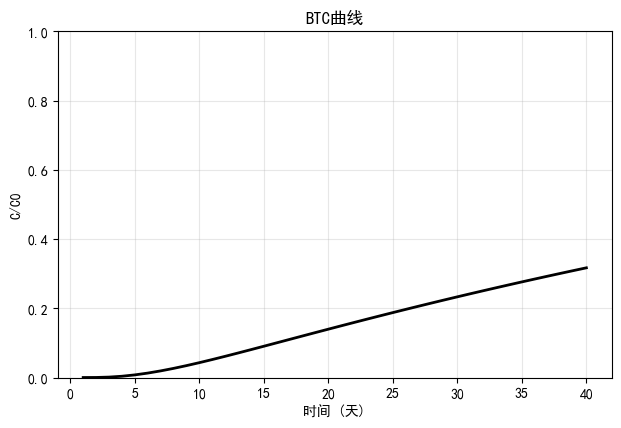


=== 模拟完成 ===
模拟时间: 40.0 天
最终大孔隙出流浓度: 0.001607 mol/L
最终小孔隙出流浓度: 0.001550 mol/L
总出流浓度: 0.001584 mol/L


In [5]:
# ===== 结果分析和绘图 =====
df_results = pd.DataFrame(BTC_result)

plt.figure(figsize=(12, 8))

# plt.subplot(2, 2, 1)
# plt.plot(df_results['time_days'], df_results['C_ma_outlet'], 'b-', label='大孔隙区域', linewidth=2)
# plt.plot(df_results['time_days'], df_results['C_im_outlet'], 'r-', label='小孔隙区域', linewidth=2)
# plt.plot(df_results['time_days'], df_results['C_total_outlet'], 'k-', label='总浓度', linewidth=2)
# plt.xlabel('时间 (天)')
# plt.ylabel('出口浓度 (mol/L)')
# plt.title('突破曲线')
# plt.legend()
# plt.grid(True, alpha=0.3)

# plt.subplot(2, 2, 2)
# C_total_final = (theta_m * C_m + theta_im * C_im) / (theta_m + theta_im)
# plt.plot(x*1000, C_m, 'b-', label='大孔隙区域', linewidth=2)
# plt.plot(x*1000, C_im, 'r-', label='小孔隙区域', linewidth=2)
# plt.plot(x*1000, C_total_final, 'k-', label='总浓度', linewidth=2)
# plt.xlabel('位置 (mm)')
# plt.ylabel('浓度 (mol/L)')
# plt.title('最终浓度分布')
# plt.legend()
# plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
plt.plot(df_results['time_days'], df_results['C_total_outlet']/c0, 'k-', linewidth=2)
plt.xlabel('时间 (天)')
plt.ylabel('C/C0')
plt.title('BTC曲线')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

# plt.subplot(2, 2, 4)
# C_diff = C_m - C_im
# plt.plot(x*1000, C_diff, 'g-', linewidth=2)
# plt.xlabel('位置 (mm)')
# plt.ylabel('浓度差 (mol/L)')
# plt.title('大孔隙与小孔隙浓度差')
# plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n=== 模拟完成 ===")
print(f"模拟时间: {time_max/86400} 天")
print(f"最终大孔隙出流浓度: {df_results['C_ma_outlet'].iloc[-1]:.6f} mol/L")
print(f"最终小孔隙出流浓度: {df_results['C_im_outlet'].iloc[-1]:.6f} mol/L")
print(f"总出流浓度: {df_results['C_total_outlet'].iloc[-1]:.6f} mol/L")

# df_results.to_csv('双孔隙突破曲线结果.csv', index=False)
# print("结果已保存到: 双孔隙突破曲线结果.csv")

结果已保存至：DP1.csv
